In [1]:
import Pkg
Pkg.activate(".")

  Activating project at `~/BME574`


In [2]:
Pkg.add(["Random","Images","Colors","MAT","LinearAlgebra","MLDatasets","Convex","SCS","DataFrames","Plots"])

   Resolving package versions...
  No Changes to `~/BME574/Project.toml`
  No Changes to `~/BME574/Manifest.toml`


In [3]:
using Images, Colors, MLDatasets, LinearAlgebra, Convex, SCS, DataFrames, Plots

In [4]:
# 3D array storage, can think about it as each image is a page in a binder
# with each page having a dimension of 28 rows of pixels by 28 columns of pixels
# access this binder by using .features
# access a specific page, i, with .features[:,:,i]
# trasnpose it to display with Gray function
tot_trainset = MNIST()

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :train
  features  =>    28×28×60000 Array{Float32, 3}
  targets   =>    60000-element Vector{Int64}

In [5]:
# reserved images for evaluating model at the end
testset = MNIST(:test)

dataset MNIST:
  metadata  =>    Dict{String, Any} with 3 entries
  split     =>    :test
  features  =>    28×28×10000 Array{Float32, 3}
  targets   =>    10000-element Vector{Int64}

In [6]:
# the 'answers' for each digit arranged in a vector
# note that the train set is randomly arranged
tot_trainset.targets

60000-element Vector{Int64}:
 5
 0
 4
 1
 9
 2
 1
 3
 1
 4
 3
 5
 3
 ⋮
 7
 8
 9
 2
 9
 5
 1
 8
 3
 5
 6
 8

In [7]:
tot_trainset.features

28×28×60000 Array{Float32, 3}:
[:, :, 1] =
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.0       0.0        0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.215686  0.533333   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.67451   0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.886275  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.992157   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.831373   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.992157  0.529412   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0        …  0.992157  0.517647   0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0           0.956863  0.0627451  0.0  0.0  0.0
 0.0  0.0  0.0  0.0  0.0  0.0117647     0.521569  0.0    

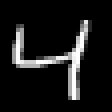

In [8]:
# method for displaying a given image from the dataset
# the array must be transposed to be right way around
Gray.(tot_trainset.features[:,:,3]')

### Units Sanity Check

In Order to make our system with the form:
$$Ax=B$$

The Dimensions need to align as follows:
$$A_{n1xm1}x_{n2xm2}=B_{n3xm3}$$

Where n_i are row dimnesions,and m_i are column dimensions
If following that matrix A will be arranged such that each row in matrix A is a row vector of an iomage in the training set, then 28X28 images will each become a row of 784 elements, and N is the number of training images, the dimesnions will be:

n1 = n3 = N

m1 = n2 = 784

m2 = m3 = 10

$$A_{Nx784}x_{784x10}=B_{Nx10}$$

In [20]:
# construct the y_i's
# iterating through a dictionary might be a good way to contruct/store them

# initialize an empty dictionary
y_js = Dict()

# use a for loop to constuct the key value pairs for each digit
# do 0 manually since is is represented by a 1 at index 10
y_js["y_0"] =vec(zeros(Int8,10))
y_js["y_0"][10] = 1
for d in 1:9
    y_js["y_$d"] =vec(zeros(Int8,10))
    y_js["y_$d"][d] = 1
end

y_js # the output is unnordered, but doesn't mmatter since will be grabbing values by keys

Dict{Any, Any} with 10 entries:
  "y_6" => Int8[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]
  "y_8" => Int8[0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
  "y_5" => Int8[0, 0, 0, 0, 1, 0, 0, 0, 0, 0]
  "y_4" => Int8[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
  "y_2" => Int8[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]
  "y_9" => Int8[0, 0, 0, 0, 0, 0, 0, 0, 1, 0]
  "y_1" => Int8[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]
  "y_7" => Int8[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]
  "y_3" => Int8[0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
  "y_0" => Int8[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [116]:
# easier to work with less images first

# the number of images in our training set that we can change after working out kinks
N = 1000

# have our training set be a slice of the whole training set
trainset = tot_trainset.features[:,:,1:N]

# get the labels for each of these
targs = tot_trainset.targets[1:N]

# Construct B given the labels---------------------------------------------------------------------------//
B =zeros(Int8,10)' # can't concatenate to an empty vector so have placeholder
for d in targs
    B = vcat(B,y_js["y_$d"]')
end
B = B[2:end,:] #remove placeholder

# Construct A by turning each image array into a row-vector of matrix A ---------------------------------//
A = vec(trainset[:,:,1])' # start with first image this time

# add in all the other rows
for i in 2:N
    A = vcat(A,vec(trainset[:,:,i])')
end

### Strategy: Use Lasso Regression Normalized by N
Lasso Regression tends towards sparsity
Using a modified lasso discussed in class:

$$\frac{1}{N} .* ||Ax-B||_2^2 + \lambda *||x||_1$$

In [117]:
# funciton to fit using lasso regression
function lasso(A,B,λ,N)
    x = Variable(size(A)[2],size(B)[2]) # initialize a decision per pixel in each image 
    problem = minimize( (1/N).*((norm(A*x-B,2))*(norm(A*x-B,2))) + λ*norm(x,1) )
    solve!(problem,SCS.Optimizer; silent = true)
    return x.value
end

lasso (generic function with 1 method)

In [118]:
# construct our model
λ=0.005
x_1 = Float64.(lasso(A,B,λ,N))

784×10 Matrix{Float64}:
 -2.37009e-15  -2.37009e-15  -2.37009e-15  …  -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15  …  -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15  …  -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
 -2.37009e-15  -2.37009e-15  -2.37009e-15     -2.37009e-15  -2.37009e-15
  ⋮                        

In [119]:
# create a function that will process the calculated B to be comprised of Y_js
# make the maximum value 1 and the rest 0
function math2yj(pred)
    for row in 1:(size(pred)[1])
        i = findmax(pred[row,:])[2] # returns the index of the max element in the row
        pred[row,:] = zeros(Int8,size(pred)[2]) # blank out the row
        pred[row,i] = 1
    end
    return pred
end

math2yj (generic function with 1 method)

In [120]:
# define a function that will process y_js into a vector of labeled guesses
function yj2label(pred_ls)
    pred_labels = []
    for row in (1:size(pred_ls)[1])
        i = findmax(pred_ls[row,:])[2]
        if i == 10
            append!(pred_labels,0)
        else
            append!(pred_labels,i)
        end
    end
    return pred_labels
end  

yj2label (generic function with 1 method)

In [300]:
# now test the predictive ability of our x matrix

function assess_model(testset,num_tests,model_x)
    # get the images and their targets for ther selected number of tests
    testset_data = testset.features[:,:,1:num_tests]
    test_targs = testset.targets[1:num_tests]
    
    
    # construct an A matrix from test images---------------------------------------//  
    Atest = vec(testset_data[:,:,1])' # start with first image this time
    # add in all the other rows
    for i in 2:(size(testset_data)[3])
        Atest = vcat(Atest,vec(testset_data[:,:,i])')
    end

    # perform Atest*Xmodel
    pred = Atest*model_x

    # need to transform output --> y'js
    pred_ls = math2yj(pred)

    # y_js --> labels
    guesses = yj2label(pred_ls)
    
    # compare the actual targets to the guesses of the model

    # pair the values and the model guesses to iterate through: True | Guess
    pairs = hcat(test_targs,guesses) 

    # create tallies for the results: Digit | # Successes | # Failures | %Accuracy
    tallies = zeros(Int32,(10,4))
    tallies[:,1] = vcat(LinRange(1,9,9),[0])
    miss_freq = zeros(Int32,10,10) # Also keep track of all the mistakes
    for pair in 1:size(pairs)[1]
        digit = pairs[pair,1]
        guess = pairs[pair,2]
        if digit == guess # guessed correctly
            if digit == 0
                tallies[10,2]+= 1
            else
                tallies[digit,2] += 1
            end
        elseif digit == 0 # guessed wrong and it was a 0 
            tallies[10,3]+= 1
            miss_freq[10,guess] += 1
        elseif guess == 0 # guessed was 0 when it wasn't
            tallies[digit,3]+= 1
            miss_freq[digit,end] += 1
        else
            tallies[digit,3]+= 1
            miss_freq[digit,guess] += 1
        end
    end
    
    # calculate for a given pair, the percent chance its misidentified as a digit given the prediction failed
    miss_freq = map(row -> (row ./ sum(row)).*100, eachrow(miss_freq))
    miss_freq = reduce(hcat, miss_freq)'
    # format as a df including a digits column
    miss_freq_df = DataFrame(hcat(zeros(Int8,10),miss_freq),:auto)
    rename!(miss_freq_df,vcat(["Digit"],[string(d) for d in vcat((1:9),[0])]))
    miss_freq_df[!,:Digit] = Int8.(vcat(1:9,[0]))

    # format the tallies as a df and calculate % Accuracy
    df = DataFrame(tallies,:auto)
    rename!(df, ["Digit", "Successes", "Failures", "%Accuracy"])
    # use anonymous function with map to calculate percent accuracy
    df[!,"%Accuracy"] = map(row -> ((row[2])/(row[2] + row[3]))*100, eachrow(tallies))
    
    tot_suc = sum(vec(df[!,:Successes]))
    tot_fail = sum(vec(df[!,:Failures]))
    ave_acc = (tot_suc/(tot_suc+tot_fail))*100
    print("Total Successes: $tot_suc | Total Failures: $tot_fail | Average Accuracy: $ave_acc%")
    return df,miss_freq_df     
end

assess_model (generic function with 1 method)

## Test Trained Model

My computer could only handle a maximum of 1,000 training images, but supported the full 10,000 images for testing. It took >30 minutes to process the training, I think I need to free up space.

In [273]:
results,fail_dist = assess_model(testset,10000,x_1);

Total Successes: 7901 | Total Failures: 2099 | Average Accuracy: 79.01%

In [274]:
results

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,1105,30,97.3568
2,2,774,258,75.0
3,3,788,222,78.0198
4,4,803,179,81.7719
5,5,558,334,62.5561
6,6,757,201,79.0188
7,7,894,134,86.965
8,8,586,388,60.1643
9,9,699,310,69.2765


In [210]:
# Each cell shows the percentage of times a digit (row) was misclassified as a different digit (column)
# when the row digit failed to be classified correctly
fail_dist

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,13.3333,10.0,3.33333,0.0,13.3333,3.33333,56.6667,0.0,0.0
2,2,38.3721,0.0,9.30233,6.97674,0.0,9.68992,13.9535,13.1783,1.16279,7.36434
3,3,9.00901,16.6667,0.0,1.35135,27.027,6.30631,18.4685,8.10811,7.65766,5.40541
4,4,13.4078,5.02793,3.91061,0.0,0.0,8.37989,2.7933,5.58659,60.3352,0.558659
5,5,5.98802,1.79641,25.4491,10.1796,0.0,6.88623,11.0778,18.5629,11.3772,8.68263
6,6,6.96517,8.45771,0.0,45.7711,16.9154,0.0,0.0,6.46766,0.0,15.4229
7,7,28.3582,9.70149,6.71642,13.4328,5.22388,0.746269,0.0,2.23881,29.8507,3.73134
8,8,25.7732,4.12371,8.24742,9.27835,12.1134,6.4433,7.98969,0.0,18.5567,7.47423
9,9,3.54839,1.29032,10.0,42.5806,1.93548,0.322581,32.9032,1.6129,0.0,5.80645


### Visualizing X & Assessing Pixel Weights

To assess the importance of different pixels in the prediction of a particular digit, we can recall that the X matrix in $AX=B$ is a set of multipliers applied to the pixels of our test set in order to produce a prediction by outputting a set of y_j's. I would argue that the magnitude of these weights are proportional to their importance in predicting the true identity of a digit as the pixels with more contribution will drive the i'th element of y_j toward 1 when predicting a digit i.

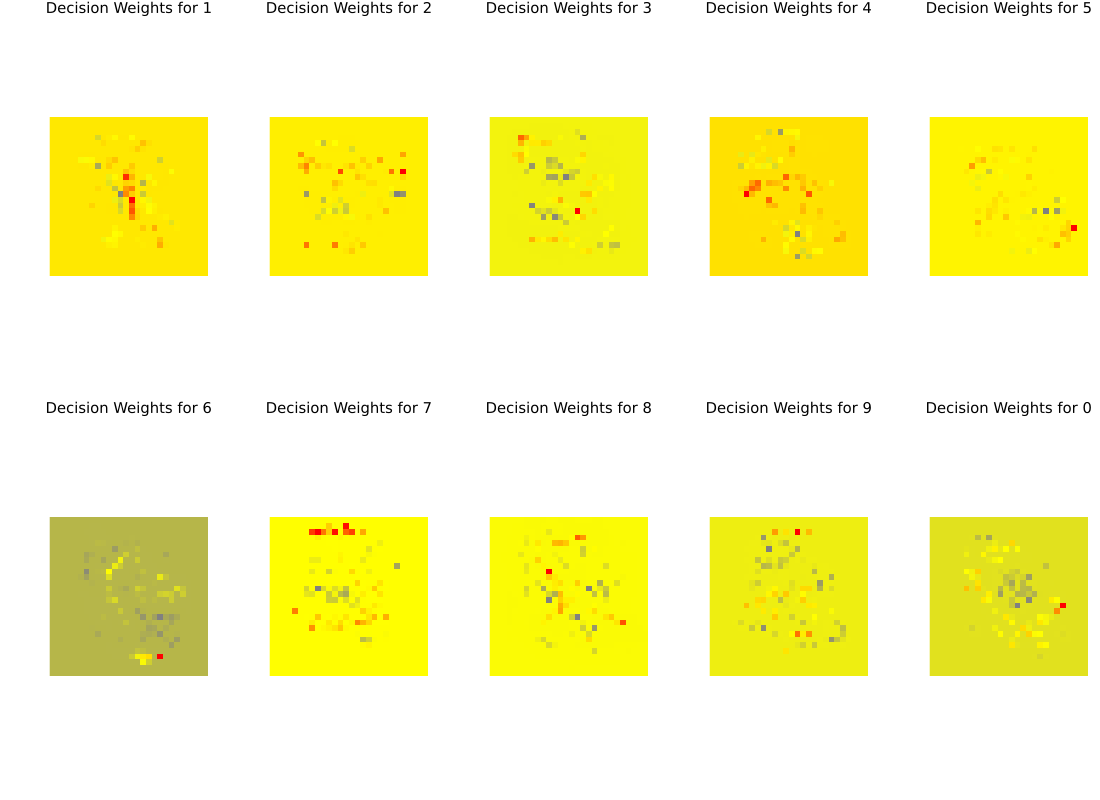

In [141]:
# constuct heatmaps for each column of X to show the pixel locations that are important towards a given digit's prediction

Plots.gr()

layout = @layout [a b c d e; f g h i j]

# place the decision weights into the format of the 28x28 image
plot(
    [heatmap(1:28,1:28,reshape(x_1[:,i],(28,28))',
    c=cgrad([:gray, :yellow, :orange, :red]),
    title = "Decision Weights for $(i == 10 ? 0 : i)" ) for i in 1:10]...,
    colorbar = false,
    axis = :off,
    grid = false,
    titlefontsize=10,
    size=(1100, 800),
    layout=layout,
    aspect_ratio=:equal,
)

In [357]:
function special_pixels(testset,x,digit,thresh,num_tests)
    # get the images and their targets for ther selected number of tests
    testset_data = testset.features[:,:,1:num_tests]
    
    # construct an A matrix from test images---------------------------------------//  
    A = vec(testset_data[:,:,1])' # start with first image this time
    # add in all the other rows
    for i in 2:(size(testset_data)[3])
        A = vcat(A,vec(testset_data[:,:,i])')
    end

    if digit == 0
        x_i = x[:,10]
    else
        x_i = x[:,digit]
    end
    idx = [i for i in eachindex(x_i) if x_i[i]>thresh]
    # collect a at the same corresponding indeces for each image and contruct a new A
    A_thresh = A[1,:][idx]'
    for r in 2:size(A)[1]
        image_thresh = A[r,:][idx]'
        A_thresh = vcat(A_thresh,image_thresh)
    end

    x_thresh = x[:,1][idx]
    for c in 2:size(x)[2]
        weight_thresh = x[:,c][idx]
        x_thresh = hcat(x_thresh,weight_thresh)
    end
    p = size(A)[2]
    z = size(A_thresh)[2]
    print("# pixels reduced from $p ==> $z")
    print(" ")
    return A_thresh,x_thresh   
end

special_pixels (generic function with 2 methods)

In [312]:
function eval_B_Special(B_t,testset,num_tests)
    
    test_targs = testset.targets[1:num_tests]
    
    
    # need to transform output --> y'js
    pred_ls = math2yj(B_t)

    # y_js --> labels
    guesses = yj2label(pred_ls)
    
    # compare the actual targets to the guesses of the model

    # pair the values and the model guesses to iterate through: True | Guess
    pairs = hcat(test_targs,guesses) 

    # create tallies for the results: Digit | # Successes | # Failures | %Accuracy
    tallies = zeros(Int32,(10,4))
    tallies[:,1] = vcat(LinRange(1,9,9),[0])
    miss_freq = zeros(Int32,10,10) # Also keep track of all the mistakes
    for pair in 1:size(pairs)[1]
        digit = pairs[pair,1]
        guess = pairs[pair,2]
        if digit == guess # guessed correctly
            if digit == 0
                tallies[10,2]+= 1
            else
                tallies[digit,2] += 1
            end
        elseif digit == 0 # guessed wrong and it was a 0 
            tallies[10,3]+= 1
            miss_freq[10,guess] += 1
        elseif guess == 0 # guessed was 0 when it wasn't
            tallies[digit,3]+= 1
            miss_freq[digit,end] += 1
        else
            tallies[digit,3]+= 1
            miss_freq[digit,guess] += 1
        end
    end
    
    # calculate for a given pair, the percent chance its misidentified as a digit given the prediction failed
    miss_freq = map(row -> (row ./ sum(row)).*100, eachrow(miss_freq))
    miss_freq = reduce(hcat, miss_freq)'
    # format as a df including a digits column
    miss_freq_df = DataFrame(hcat(zeros(Int8,10),miss_freq),:auto)
    rename!(miss_freq_df,vcat(["Digit"],[string(d) for d in vcat((1:9),[0])]))
    miss_freq_df[!,:Digit] = Int8.(vcat(1:9,[0]))

    # format the tallies as a df and calculate % Accuracy
    df = DataFrame(tallies,:auto)
    rename!(df, ["Digit", "Successes", "Failures", "%Accuracy"])
    # use anonymous function with map to calculate percent accuracy
    df[!,"%Accuracy"] = map(row -> ((row[2])/(row[2] + row[3]))*100, eachrow(tallies))
    
    tot_suc = sum(vec(df[!,:Successes]))
    tot_fail = sum(vec(df[!,:Failures]))
    ave_acc = (tot_suc/(tot_suc+tot_fail))*100
    print("Total Success: $tot_suc | Total Failures: $tot_fail | Average Accuracy: $ave_acc%")
    
    return df,miss_freq_df    
end

eval_B_Special (generic function with 1 method)

In [256]:
function hmap(col)
    # plotting each indivdual so I can see the color bar and choose thresh
    heatmap(1:28,1:28,reshape(x_1[:,col],(28,28))',
    c=cgrad([:gray, :yellow, :orange, :red]),
    title = "Decision Weights for $(col == 10 ? 0 : col)",
    axis = :off,
    grid=false,
    aspect_ratio=:equal 
    )
end

hmap (generic function with 1 method)

## Thresholding Key Pixels For Predicting 1

**For each of the digits, I manually selected an approximate threshold for which the majority of the heatmap was sparse to reduce the number of pixels. In each case, the accuracy for identifying the optimized digit increased to ~100% but also decreased the ability of the model to identify other digits, and in some instances intorducing increased false positives for the optimized digit. The pixel reductions are listed, the overall changes in accuracy, as well as the digit specific identification break-down ** 

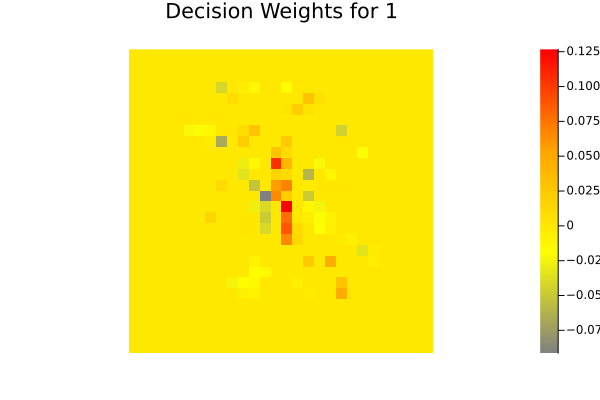

In [359]:
hmap(1)

In [360]:
thresh1 = 0.0125
A_t1,x_t1 = special_pixels(testset,x_1,1,thresh1,1000)
B_t1 = A_t1*x_t1
results_t1,fail_dist_t1 = eval_B_Special(B_t1,testset,1000)
results_t1

# pixels reduced from 784 ==> 23 Total Success: 127 | Total Failures: 873 | Average Accuracy: 12.7%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,126,0,100.0
2,2,0,116,0.0
3,3,0,107,0.0
4,4,0,110,0.0
5,5,0,87,0.0
6,6,0,87,0.0
7,7,0,99,0.0
8,8,0,89,0.0
9,9,0,94,0.0


In [361]:
fail_dist_t1

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,5,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,6,98.8506,1.14943,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,7,97.9798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0202
8,8,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,9,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 2

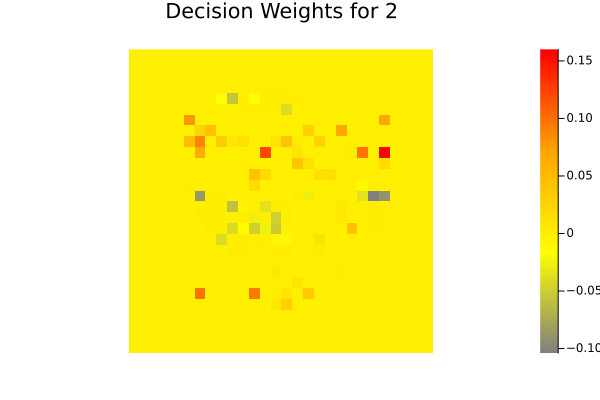

In [362]:
hmap(2)

In [363]:
thresh2 = -.025
A_t2,x_t2 = special_pixels(testset,x_1,2,thresh2,1000)
B_t2 = A_t2*x_t2
results_t2,fail_dist_t2 = eval_B_Special(B_t2,testset,1000)
results_t2

# pixels reduced from 784 ==> 768 Total Success: 699 | Total Failures: 301 | Average Accuracy: 69.89999999999999%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,124,2,98.4127
2,2,90,26,77.5862
3,3,56,51,52.3364
4,4,86,24,78.1818
5,5,47,40,54.023
6,6,53,34,60.9195
7,7,82,17,82.8283
8,8,30,59,33.7079
9,9,57,37,60.6383


In [364]:
fail_dist_t2

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,50.0,0.0,0.0,0.0,0.0,0.0,50.0,0.0,0.0
2,2,53.8462,0.0,0.0,0.0,0.0,7.69231,15.3846,19.2308,0.0,3.84615
3,3,11.7647,45.098,0.0,0.0,19.6078,1.96078,9.80392,3.92157,5.88235,1.96078
4,4,16.6667,25.0,0.0,0.0,4.16667,4.16667,0.0,0.0,50.0,0.0
5,5,12.5,35.0,2.5,5.0,0.0,10.0,20.0,10.0,2.5,2.5
6,6,5.88235,76.4706,0.0,2.94118,2.94118,0.0,0.0,0.0,0.0,11.7647
7,7,41.1765,17.6471,5.88235,5.88235,0.0,0.0,0.0,0.0,29.4118,0.0
8,8,27.1186,52.5424,3.38983,1.69492,3.38983,1.69492,3.38983,0.0,3.38983,3.38983
9,9,2.7027,24.3243,5.40541,45.9459,0.0,0.0,21.6216,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 3

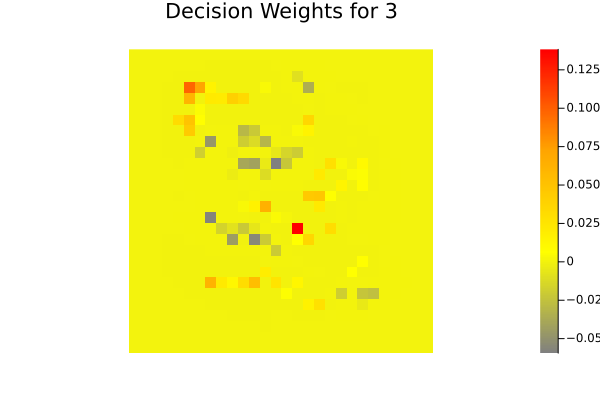

In [365]:
hmap(3)

In [389]:
thresh3 = 0
A_t3,x_t3 = special_pixels(testset,x_1,3,thresh3,1000)
B_t3 = A_t3*x_t3
results_t3,fail_dist_t3 = eval_B_Special(B_t3,testset,1000)
results_t3

# pixels reduced from 784 ==> 281 Total Success: 407 | Total Failures: 593 | Average Accuracy: 40.699999999999996%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,80,46,63.4921
2,2,26,90,22.4138
3,3,106,1,99.0654
4,4,70,40,63.6364
5,5,5,82,5.74713
6,6,29,58,33.3333
7,7,26,73,26.2626
8,8,6,83,6.74157
9,9,0,94,0.0


In [390]:
fail_dist_t3

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,93.3333,4.44444,0.0,1.11111,0.0,1.11111,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0
4,4,0.0,2.5,95.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5
5,5,1.21951,0.0,80.4878,14.6341,0.0,0.0,1.21951,1.21951,0.0,1.21951
6,6,0.0,3.44828,65.5172,20.6897,0.0,0.0,0.0,0.0,0.0,10.3448
7,7,0.0,1.36986,95.8904,1.36986,0.0,0.0,0.0,0.0,0.0,1.36986
8,8,0.0,0.0,98.7952,1.20482,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.0,0.0,65.9574,31.9149,0.0,0.0,2.12766,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 4

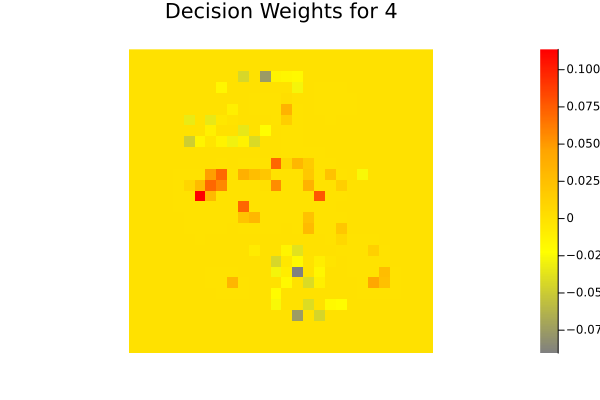

In [368]:
hmap(4)

In [369]:
thresh4 = 0
A_t4, x_t4 = special_pixels(testset, x_1, 4, thresh4, 1000)
B_t4 = A_t4 * x_t4
results_t4, fail_dist_t4 = eval_B_Special(B_t4, testset, 1000)
results_t4

# pixels reduced from 784 ==> 289 Total Success: 318 | Total Failures: 682 | Average Accuracy: 31.8%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,93,33,73.8095
2,2,36,80,31.0345
3,3,5,102,4.6729
4,4,110,0,100.0
5,5,2,85,2.29885
6,6,9,78,10.3448
7,7,41,58,41.4141
8,8,0,89,0.0
9,9,0,94,0.0


In [370]:
fail_dist_t4

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,3.0303,0.0,93.9394,3.0303,0.0,0.0,0.0,0.0,0.0
2,2,1.25,0.0,0.0,93.75,0.0,1.25,1.25,1.25,0.0,1.25
3,3,0.980392,2.94118,0.0,88.2353,2.94118,0.0,3.92157,0.0,0.0,0.980392
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,1.17647,0.0,1.17647,89.4118,0.0,0.0,5.88235,0.0,0.0,2.35294
6,6,0.0,0.0,0.0,98.7179,0.0,0.0,0.0,0.0,0.0,1.28205
7,7,0.0,0.0,0.0,98.2759,1.72414,0.0,0.0,0.0,0.0,0.0
8,8,1.1236,1.1236,0.0,97.7528,0.0,0.0,0.0,0.0,0.0,0.0
9,9,0.0,0.0,0.0,97.8723,0.0,0.0,2.12766,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 5

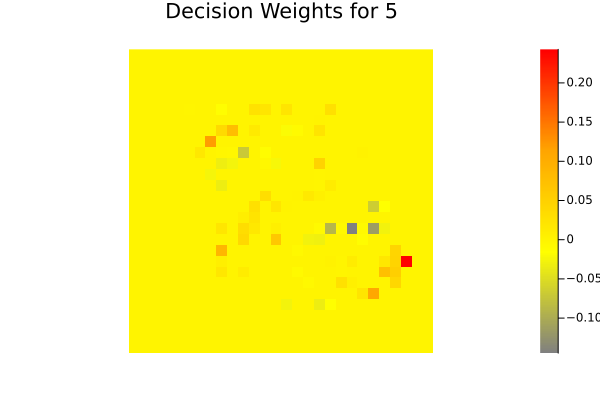

In [371]:
hmap(5)

In [372]:
thresh5 = 0
A_t5, x_t5 = special_pixels(testset, x_1, 5, thresh5, 1000)
B_t5 = A_t5 * x_t5
results_t5, fail_dist_t5 = eval_B_Special(B_t5, testset, 1000)
results_t5

# pixels reduced from 784 ==> 355 Total Success: 418 | Total Failures: 582 | Average Accuracy: 41.8%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,120,6,95.2381
2,2,6,110,5.17241
3,3,20,87,18.6916
4,4,59,51,53.6364
5,5,84,3,96.5517
6,6,48,39,55.1724
7,7,78,21,78.7879
8,8,0,89,0.0
9,9,0,94,0.0


In [373]:
fail_dist_t5

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,0.0,16.6667,0.0,83.3333,0.0,0.0,0.0,0.0,0.0
2,2,5.45455,0.0,0.909091,0.909091,82.7273,4.54545,5.45455,0.0,0.0,0.0
3,3,2.29885,0.0,0.0,2.29885,89.6552,0.0,5.74713,0.0,0.0,0.0
4,4,1.96078,0.0,1.96078,0.0,94.1176,0.0,1.96078,0.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0
6,6,2.5641,0.0,0.0,17.9487,79.4872,0.0,0.0,0.0,0.0,0.0
7,7,19.0476,0.0,4.7619,9.52381,66.6667,0.0,0.0,0.0,0.0,0.0
8,8,3.37079,0.0,0.0,0.0,96.6292,0.0,0.0,0.0,0.0,0.0
9,9,1.06383,0.0,0.0,26.5957,52.1277,0.0,20.2128,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 6

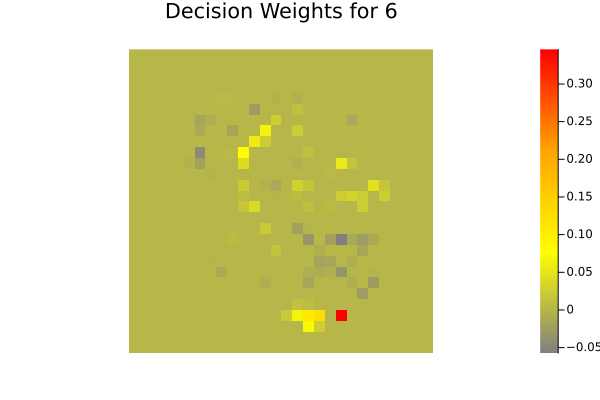

In [374]:
hmap(6)

In [375]:
thresh6 = 0.02
A_t6, x_t6 = special_pixels(testset, x_1, 6, thresh6, 1000)
B_t6 = A_t6 * x_t6
results_t6, fail_dist_t6 = eval_B_Special(B_t6, testset, 1000)
results_t6

# pixels reduced from 784 ==> 24 Total Success: 90 | Total Failures: 910 | Average Accuracy: 9.0%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,0,126,0.0
2,2,0,116,0.0
3,3,0,107,0.0
4,4,0,110,0.0
5,5,0,87,0.0
6,6,87,0,100.0
7,7,0,99,0.0
8,8,3,86,3.37079
9,9,0,94,0.0


In [376]:
fail_dist_t6

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,0.0,0.0,0.0,0.0,99.2063,0.0,0.793651,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,96.5517,0.0,3.44828,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,99.0909,0.0,0.909091,0.0,0.0
5,5,1.14943,0.0,0.0,0.0,0.0,98.8506,0.0,0.0,0.0,0.0
6,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
8,8,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0
9,9,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 7

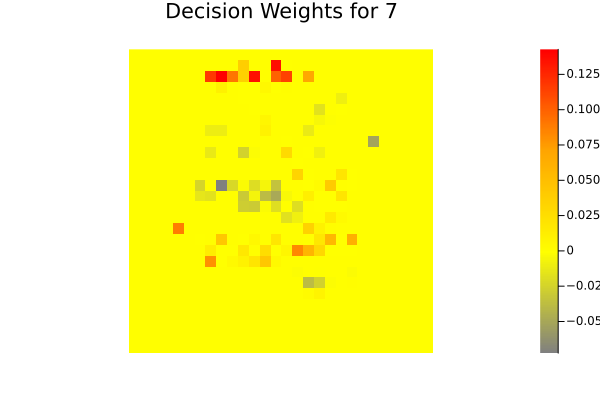

In [377]:
hmap(7)

In [378]:
thresh7 = 0
A_t7, x_t7 = special_pixels(testset, x_1, 7, thresh7, 1000)
B_t7 = A_t7 * x_t7
results_t7, fail_dist_t7 = eval_B_Special(B_t7, testset, 1000)
results_t7

# pixels reduced from 784 ==> 318 Total Success: 374 | Total Failures: 626 | Average Accuracy: 37.4%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,120,6,95.2381
2,2,72,44,62.069
3,3,38,69,35.514
4,4,11,99,10.0
5,5,23,64,26.4368
6,6,5,82,5.74713
7,7,98,1,98.9899
8,8,0,89,0.0
9,9,0,94,0.0


In [379]:
fail_dist_t7

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,16.6667,33.3333,0.0,0.0,0.0,50.0,0.0,0.0,0.0
2,2,9.09091,0.0,0.0,0.0,0.0,0.0,90.9091,0.0,0.0,0.0
3,3,0.0,13.0435,0.0,0.0,4.34783,1.44928,81.1594,0.0,0.0,0.0
4,4,1.0101,3.0303,2.0202,0.0,1.0101,0.0,92.9293,0.0,0.0,0.0
5,5,1.5625,9.375,7.8125,1.5625,0.0,0.0,79.6875,0.0,0.0,0.0
6,6,1.21951,31.7073,0.0,0.0,6.09756,0.0,60.9756,0.0,0.0,0.0
7,7,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,8,5.61798,3.37079,1.1236,0.0,2.24719,0.0,87.6404,0.0,0.0,0.0
9,9,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 8

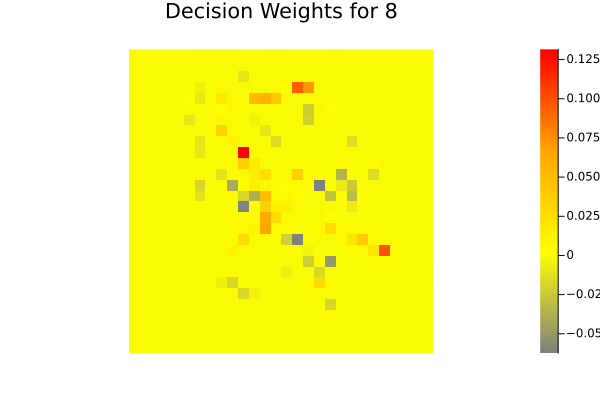

In [380]:
hmap(8)

In [381]:
thresh8 = 0.0125
A_t8, x_t8 = special_pixels(testset,x_1,8,thresh8,1000)
B_t8 = A_t8*x_t8
results_t8,fail_dist_t8 = eval_B_Special(B_t8,testset,1000)
results_t8

# pixels reduced from 784 ==> 28 Total Success: 128 | Total Failures: 872 | Average Accuracy: 12.8%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,39,87,30.9524
2,2,0,116,0.0
3,3,0,107,0.0
4,4,0,110,0.0
5,5,0,87,0.0
6,6,0,87,0.0
7,7,0,99,0.0
8,8,89,0,100.0
9,9,0,94,0.0


In [382]:
fail_dist_t8

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
2,2,2.58621,0.0,0.0,0.0,0.0,0.0,0.0,97.4138,0.0,0.0
3,3,0.934579,0.0,0.0,0.0,0.0,0.0,0.0,99.0654,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
5,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
6,6,0.0,0.0,0.0,0.0,1.14943,0.0,0.0,98.8506,0.0,0.0
7,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0
8,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,0.0,1.06383,0.0,0.0,0.0,0.0,0.0,98.9362,0.0,0.0


## Thresholding Key Pixels For Predicting 9

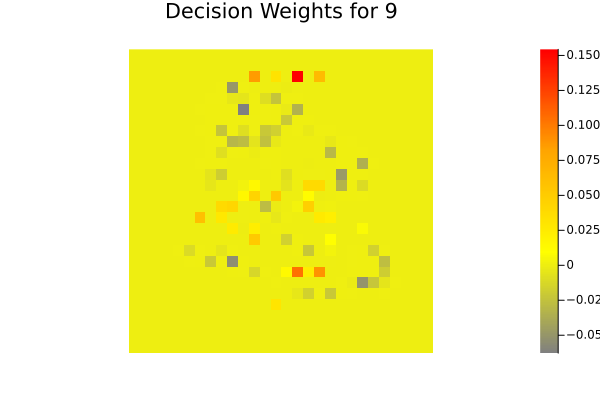

In [383]:
hmap(9)

In [384]:
thresh9 = 0
A_t9, x_t9 = special_pixels(testset, x_1, 9, thresh9, 1000)
B_t9 = A_t9 * x_t9
results_t9, fail_dist_t9 = eval_B_Special(B_t9, testset, 1000)
results_t9

# pixels reduced from 784 ==> 323 Total Success: 438 | Total Failures: 562 | Average Accuracy: 43.8%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,117,9,92.8571
2,2,40,76,34.4828
3,3,45,62,42.0561
4,4,2,108,1.81818
5,5,5,82,5.74713
6,6,49,38,56.3218
7,7,20,79,20.202
8,8,6,83,6.74157
9,9,93,1,98.9362


In [385]:
fail_dist_t9

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,0.0,77.7778,0.0,0.0,0.0,0.0,0.0,22.2222,0.0
2,2,2.63158,0.0,6.57895,0.0,0.0,3.94737,0.0,1.31579,85.5263,0.0
3,3,0.0,1.6129,0.0,0.0,1.6129,0.0,0.0,0.0,95.1613,1.6129
4,4,0.925926,0.0,0.0,0.0,0.0,1.85185,0.0,0.0,96.2963,0.925926
5,5,0.0,0.0,4.87805,0.0,0.0,0.0,1.21951,0.0,91.4634,2.43902
6,6,2.63158,2.63158,2.63158,0.0,0.0,0.0,0.0,0.0,81.5789,10.5263
7,7,1.26582,0.0,3.79747,0.0,0.0,0.0,0.0,0.0,94.9367,0.0
8,8,1.20482,1.20482,2.40964,0.0,1.20482,0.0,0.0,0.0,93.9759,0.0
9,9,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Thresholding Key Pixels For Predicting 0

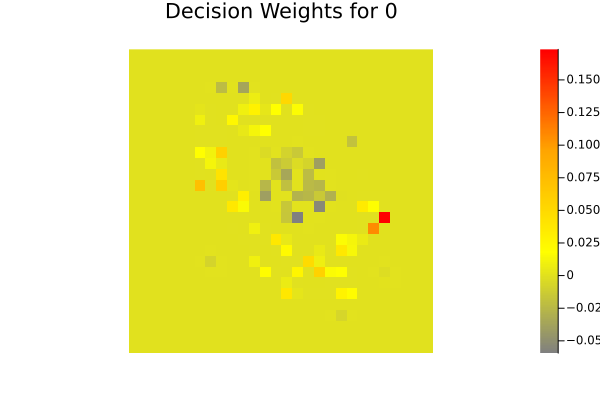

In [386]:
hmap(10)

In [387]:
thresh0 = 0
A_t0, x_t0 = special_pixels(testset, x_1, 0, thresh0, 1000)
B_t0 = A_t0 * x_t0
results_t0, fail_dist_t0 = eval_B_Special(B_t0, testset, 1000)
results_t0

# pixels reduced from 784 ==> 257 Total Success: 324 | Total Failures: 676 | Average Accuracy: 32.4%

Row,Digit,Successes,Failures,%Accuracy
,Int32,Int32,Int32,Float64
1,1,91,35,72.2222
2,2,3,113,2.58621
3,3,19,88,17.757
4,4,24,86,21.8182
5,5,1,86,1.14943
6,6,29,58,33.3333
7,7,55,44,55.5556
8,8,0,89,0.0
9,9,17,77,18.0851


In [388]:
fail_dist_t0

Row,Digit,1,2,3,4,5,6,7,8,9,0
,Int8,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,1,0.0,0.0,31.4286,2.85714,0.0,2.85714,0.0,0.0,0.0,62.8571
2,2,1.76991,0.0,1.76991,0.0,0.0,7.07965,1.76991,0.0,0.0,87.6106
3,3,0.0,1.13636,0.0,0.0,0.0,0.0,2.27273,0.0,0.0,96.5909
4,4,0.0,1.16279,4.65116,0.0,0.0,1.16279,0.0,0.0,10.4651,82.5581
5,5,0.0,0.0,0.0,0.0,0.0,0.0,3.48837,0.0,0.0,96.5116
6,6,0.0,0.0,0.0,5.17241,0.0,0.0,0.0,0.0,0.0,94.8276
7,7,0.0,0.0,9.09091,2.27273,0.0,0.0,0.0,0.0,9.09091,79.5455
8,8,0.0,0.0,3.37079,1.1236,2.24719,0.0,0.0,0.0,0.0,93.2584
9,9,0.0,0.0,3.8961,6.49351,0.0,0.0,3.8961,0.0,0.0,85.7143


---
## BME 574 Midterm Exam (take-home)

The dataset above is the famous MNIST dataset of handwritten digits (28x28 grayscale images).
The challenge for this midterm is to find the most informative pixels for each digit from this dataset
using techniques that you have learning previously.  Here is how to start:
1. Create a set of output (label) vectors $\{y_j\}$ of length 10 that represent the labels (0-9)
here are a few examples:
$$
\begin{align}
^{"}1^{"}=\begin{bmatrix} 1\\0\\0\\ \vdots \\0 \end{bmatrix}
\end{align}
$$
$$
\begin{align}
^{"}3^{"}=\begin{bmatrix} 0\\0\\1\\ \vdots \\0 \end{bmatrix}
\end{align}
$$
$$
\begin{align}
^{"}0^{"}=\begin{bmatrix} 0\\0\\0\\ \vdots \\1 \end{bmatrix}
\end{align}
$$
2. Now let $B$ be the set of output (label) vectors

$$
\begin{align}
B = \begin{bmatrix} y_{1} & y_{2} & y_{3} & \ldots & y_{n}\end{bmatrix}
\end{align}
$$

3. Let the matrix $A$ be the corresponding reshaped (vectorized) MNIST images (one in each row)

$$
\begin{align}
A = \begin{bmatrix} x_{1} & x_{2} & x_{3} & \ldots & x_{n}\end{bmatrix}
\end{align}
$$

4. $AX = B$ maps from the image space to the label space

Your task is to use solvers for $AX=B$ that promote sparsity to rank the pixels in the MNIST dataset that are most informative for correctly labeling the digits. You will have to come up with your own heuristics or empirical rules for this. Be sure to visualize the results from X. Apply your most important pixels to the test data set to see how accurate you are with as few pixels as possible. Redo the analysis with each digit individually to ﬁnd the most important pixels for each digit. Think about the interpretation of what you are doing with this $AX = B$ problem.
Hint: for testing, it may be a good idea to start with a smaller dataset (e.g. 1000 images)